In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [40]:
def generate_by_template(template, class_num, ot = -5, to = 5, count = 100):
    offs = np.random.rand(10)
    arr = np.linspace(ot, to, count)
    result = {'arr' : [], 'class' : class_num}
    for i in range(10):
        result['arr'].append(template(arr+offs[i])+np.random.normal(size = 100, scale= 0.1))
    return result 

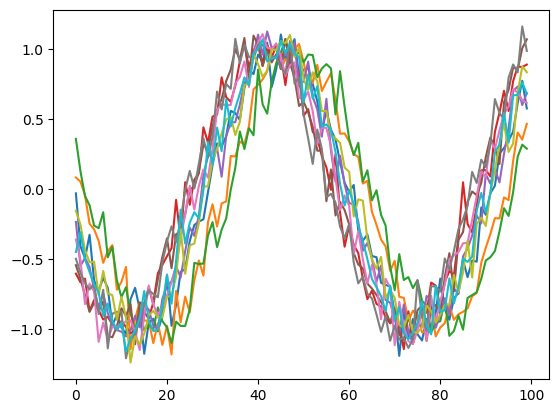

In [41]:
ts1 = generate_by_template(np.cos, 0)
for ts in ts1['arr']:
    plt.plot(ts)

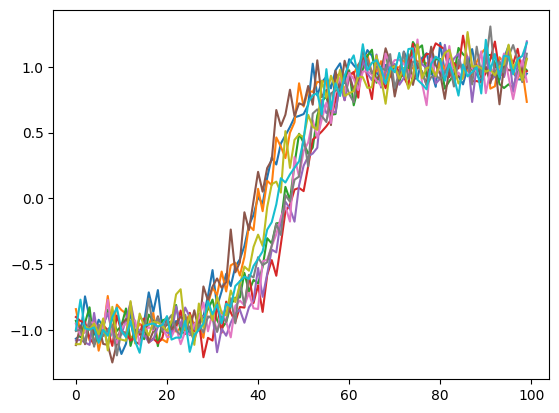

In [42]:
ts2 = generate_by_template(np.tanh, 1)
for ts in ts2['arr']:
    plt.plot(ts)

In [43]:
def normalize(arr):
    res = np.array(arr)
    res = (res-res.min())/(res.max()-res.min())
    return res.tolist()

In [44]:
from dtaidistance import ed
def CalculateDistance(ts, slise):
    size = len(slise)
    min_dis = None
    for i in range(0, len(ts)-size+1):
        dis = ed.distance(slise, ts[i:i+size])
        if min_dis == None:
            min_dis = dis
        elif dis < min_dis:
            min_dis = dis
    return min_dis

In [45]:
def CalculateDistances(S, arr):
    distances = []
    for Wsl in arr:
        for s in Wsl['arr']:
            distances.append({'arr' : CalculateDistance(S,normalize(s)), 'class' : Wsl['class']})
    return distances

In [46]:
def GenerateCandidates(ts, min, max):
    shaplets = []
    for l in range(min, max+1):
        for index in range(0, 100-l+1):
                        shaplets.append({'arr' : normalize(ts['arr'][index:index+l]), 'class' : ts['class']})
    return shaplets

In [ ]:
def makeTS(TS):
    res = []
    for ts in TS:
        for arrs in ts['arr']: 
            res.append({'arr' : arrs, 'class' : ts['class']})
    return res

In [47]:

def GenerateShaplets(TS, calsses_num, min = 3, max = 100, r = 10*100, quality = 0.05):
    result = []
    tss = makeTS(TS)
    for ts in TS:
        shaplets = []
        for s in ts:
            Wsl = GenerateCandidates(makeTS([s]), min, max)
            for S in Wsl:
                    D = CalculateDistances(S, Wsl)
                    print(D)
                    
            result.append(shaplets)
    return result

In [48]:
arr = GenerateShaplets([ts1,ts2], 2, 3, 5)
arr[0][0]

TypeError: unhashable type: 'slice'